# Housing affordability

![Logo][sibor]

1. It has been reported in the [papers] that resales prices are coming down
2. Interest rates for bank housing loans are on the rise together with the possible Fed rate hike and sibor increase.
3. Recently I've booked a new flat from HDB however HDB is dragging their feet in confirming the followup appointment for finalising the sales agreement, I'm considering the purchase a ready resale unit instead forgoing the 2k option fee.
4. Three years ago resale prices were high and especially so for matured estates. I couldnt afford a resale flat to be near my parents so I had to rent and travel around like a nomad. It is really tiring and difficult especially when you have children.
5. It will be useful to evalute if the rental cost + the cost of a new BTO unit would still be cheaper than purchasing a similar resale unit.
6. We shall try to find out if a typical household with dual median income is able to afford a median resale flat in Singapore with only a CPF loan/bank loan without monthly cash topups.
7. Fortunately [Data.gov.sg] offers HDB resale transcations data from 1990 to current month
8. While [MoM] provides a spreadsheet download of the annual median wage for Singapore residents from 2001-2016
9. It is noted that ownership of HDB resale flats are only avaliable to both Singapore PRs and citizens, so it safe to assume HDB resale transactions are conducted between Singapore residents and the median income used to compute the maximum CPF loan is ceiling representative of a general Singapore house buyer.

[papers]: http://www.businesstimes.com.sg/real-estate/hdb-resale-prices-retreat-06-m-o-m-in-july-but-volume-up-18-srx
[sibor]: http://cdn-cms.pgimgs.com/news/2016/09/Figure-1-SIBOR-SOR-Charts-v2-e1474855552532-1024x620.jpg
[Data.gov.sg]: https://data.gov.sg/dataset/resale-flat-prices
[MoM]: http://stats.mom.gov.sg/Pages/Income-Summary-Table.aspx

### HDB resale transactions - 100330 records

In [8]:
# Parse HDB Data
# Combining all the downloaded csv together
#  - 'Resale transacted prices.'
#  - 'Prior to March 2012, data is based on date of approval for the resale transactions.'
#  - 'For March 2012 onwards, the data is based on date of registration for the resale
#    transactions.'

dfa = pd.read_csv(csvafilename, parse_dates=['month'], header=0)
dfb = pd.read_csv(csvbfilename, parse_dates=['month'], header=0)
dfc = pd.read_csv(csvcfilename, parse_dates=['month'], header=0)

df = pd.concat([dfc,dfb,dfa],axis=0)
df.tail()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
100326,2017-06-01,YISHUN,EXECUTIVE,326,YISHUN RING RD,10 TO 12,153.0,Maisonette,1988,590000.0
100327,2017-06-01,YISHUN,EXECUTIVE,792,YISHUN RING RD,07 TO 09,142.0,Apartment,1987,525000.0
100328,2017-06-01,YISHUN,EXECUTIVE,326,YISHUN RING RD,10 TO 12,142.0,Apartment,1988,585000.0
100329,2017-06-01,YISHUN,EXECUTIVE,293,YISHUN ST 22,01 TO 03,169.0,Apartment,1992,600000.0
100330,2017-06-01,YISHUN,EXECUTIVE,614,YISHUN ST 61,07 TO 09,146.0,Maisonette,1987,590000.0


### Median Wages

In [9]:
# Parse MoM Data

headers =  ['Total_CPF','FullTime','Parttime','Total_noCPF','FullTime_noCPF','Parttime_noCPF']
xls = pd.read_excel(xlsxfilename,index_col=0,header=None, names=headers,skiprows=7,skip_footer=8,na_values='n.a.').reset_index()

# Drop everything else , only interested in Gross Wage excluding employeers CPF
income = xls[[0, 'FullTime_noCPF']].drop([7])
income.tail()

,0,FullTime_noCPF
12,2012,3000.0
13,2013,3250.0
14,2014,3276.0
15,2015,3467.0
16,2016,3500.0


### Aggregate HDB transactions by type

In [10]:
# Data Munging
# Timeseries of average resale price for various types of flats groupby town
avg_bb = df.groupby(['month','flat_type'])['resale_price'].median()

# Transform pivot table
t=avg_bb.unstack(level=1)
t.tail()

flat_type,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI GENERATION,MULTI-GENERATION
month,,,,,,,,
2017-02-01,NaN,238000.0,305000.0,408000.0,485000.0,587000.0,NaN,NaN
2017-03-01,209000.0,255500.0,305250.0,415888.0,477500.0,604944.0,NaN,NaN
2017-04-01,NaN,235000.0,304000.0,400000.0,488000.0,593500.0,NaN,NaN
2017-05-01,217000.0,241500.0,305000.0,405000.0,480000.0,587500.0,NaN,NaN
2017-06-01,NaN,241000.0,308000.0,408000.0,467000.0,610000.0,NaN,NaN


In [11]:
# NPV of a series of cashflows ,with interest compounded annually
def NPV (mthpay=100,yrs=30,start=0,pa=0.1):
    sum = 0
    for x in range(int(start),int(start+abs(yrs*12))):
        sum += mthpay/(1+pa/12)**x #Simple monthly interest
    return sum

OArate=0.23
yrsloan=25
intrate=0.026
NfYperhouse=2

# Use Fulltime wages without employer CFP , ammount that goes into CPFOA account is 23% from Yr 2010 onwards
totalCPFloan=pd.DataFrame()
totalCPFloan['Year']=income[0]
totalCPFloan['FullTime_noCPF']=income['FullTime_noCPF'].map(lambda x: NPV(mthpay=(x*NfYperhouse*OArate),yrs=yrsloan,pa=intrate))

OArate=0.23
yrsloan=30
intrate=0.01
NfYperhouse=2

# Use Fulltime wages without employer CFP , ammount that goes into CPFOA account is 23% from Yr 2010 onwards
totalBANKloan=pd.DataFrame()
totalBANKloan['Year']=income[0]
totalBANKloan['FullTime_noCPF']=income['FullTime_noCPF'].map(lambda x: NPV(mthpay=(x*NfYperhouse*OArate),yrs=yrsloan,pa=intrate))

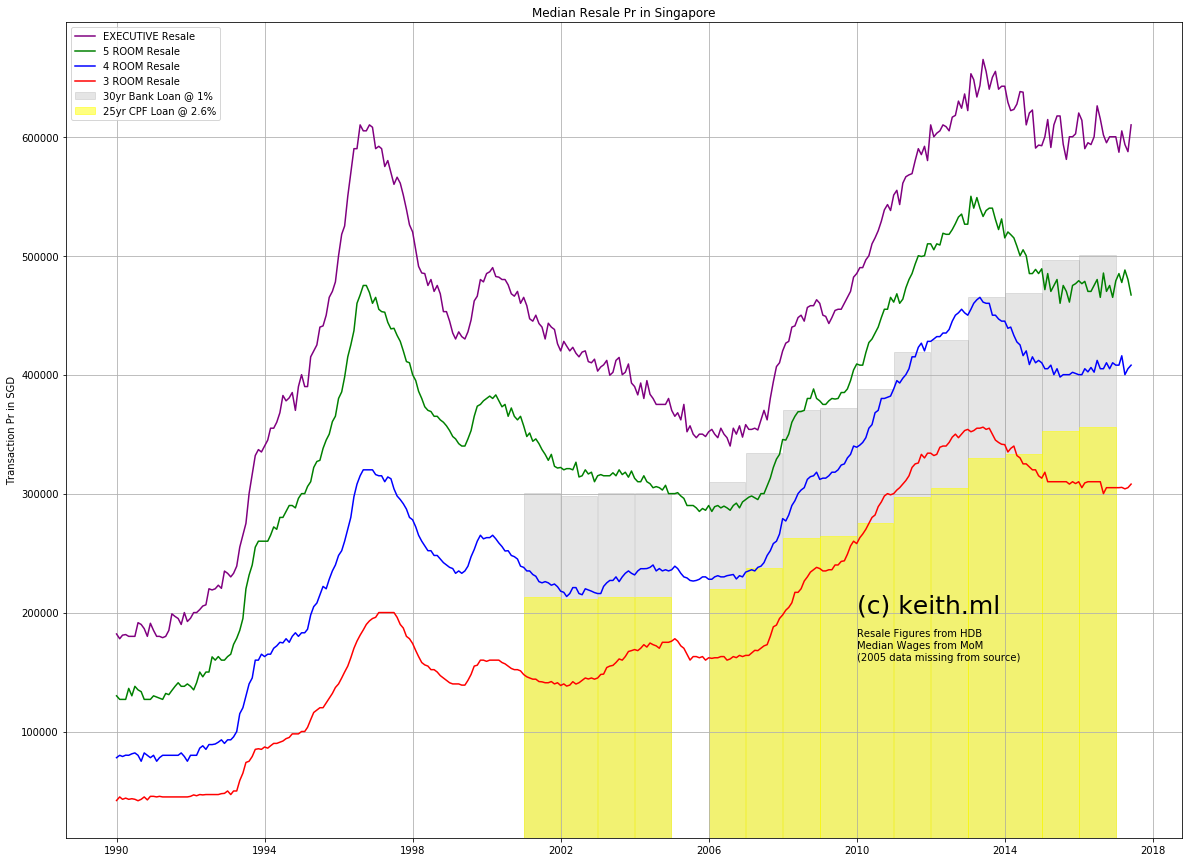

In [ ]:
# Plot Static Chart

plt.figure(figsize=(20,15))
plt.plot(t['EXECUTIVE'], color='purple', label='EXECUTIVE Resale')
plt.plot(t['5 ROOM'], color='green', label='5 ROOM Resale')
plt.plot(t['4 ROOM'], color='blue', label='4 ROOM Resale')
plt.plot(t['3 ROOM'], color='red', label='3 ROOM Resale')
plt.title("Median Resale Pr in Singapore")
plt.ylabel("Transaction Pr in SGD")
plt.grid(True)

# Plot Bank loan ceiling for yr 2001 to yr 2016
for index, row in totalBANKloan.iterrows():
    startTime = datetime(row[0],1,1)
    endTime = datetime(row[0],12,30)
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start
    if index == 0:
        rect = Rectangle((start, 0), width, row[1], color='grey', alpha=0.2, label='30yr Bank Loan @ 1%')
    else:
        rect = Rectangle((start, 0), width, row[1], color='grey', alpha=0.2)
    plt.gca().add_patch(rect)

# Plot CPF loan ceiling for yr 2001 to yr 2016
for index, row in totalCPFloan.iterrows():
    startTime = datetime(row[0],1,1)
    endTime = datetime(row[0],12,30)
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start
    if index == 0:
        rect = Rectangle((start, 0), width, row[1], color='yellow', alpha=0.5, label='25yr CPF Loan @ 2.6%')
    else:
        rect = Rectangle((start, 0), width, row[1], color='yellow', alpha=0.5)    
    plt.gca().add_patch(rect)

plt.text(datetime(2010,1,1), 200000, r'(c) writing.mlops.im', fontsize=25)
plt.text(datetime(2010,1,1), 180000, r'Resale Figures from HDB', fontsize=10)
plt.text(datetime(2010,1,1), 170000, r'Median Wages from MoM', fontsize=10)
plt.text(datetime(2010,1,1), 160000, r'(2005 data missing from source)', fontsize=10)
plt.legend()
plt.show()

## Notes:

1. For a 25 year CPF loan, the largest a typical median household in singapore can generally afford is a 3 room resale flat.
2. Resale prices peaked between 2013 and 2014. 
3. This peak of 2014 exceeded the peak in 1997 (Asian financial crisis)
4. Between 2010 and 2014 median resale prices were rising faster than median wage growth. 
5. As such median resale flats of all types were **NOT** within reach of typical families with 25yr CPF loans @ 2.6% interests.
6. It seems that resale prices have stabilised over the past 2 years
6. **TODO**: Integrate volume of transactions over time
7. **TODO**: See if there are any trends if we normalise the price by the area

### Annex

http://www.todayonline.com/singapore/hdb-shortens-homebuyers-loan-tenure-25-years

Published  5:34 PM, August 27, 2013  
Updated 9:50 AM, August 28, 2013 

SINGAPORE — With immediate effect, the Housing and Development Board (HDB) has shortened its maximum loan tenure to 25 years and the mortgage servicing ratio (MSR) limit has also been cut to 30 per cent of the borrower’s gross monthly salary.

Previously, HDB loan tenures were at 30 years and the MSR limit was at 35 per cent of the borrower’s gross monthly salary.

From tomorrow (Aug 28), financial institutions will in tandem reduce the maximum tenure of new housing loans and re-financing facilities from 35 years to 30 years.

With immediate effect as well, Permanent Residents (PR) who want to buy resale flats will have to wait three years after receiving their PR status. Prior to this change, they could buy a flat as soon as they received PR status.

Announcing these changes today, the HDB also provided more details of the extension of the Special Housing Grant (SHG) and the new step-up housing grant, which Prime Minster Lee Hsien Loong first announced during the National Day Rally.

The income ceiling for SHG will be raised significantly, from S\$2,250 a month to S\$6,500 a month for families and S\$3,250 for singles. Mr Lee previously announced that the SHG would be extended to middle-income households and could be used for buying new four-room flats.

Under the new step up grant, families who want to upgrade from a two-room to a three-room flat can get a housing grant of S$15,000. 